# Optical circuits for preparing non-Gaussian states

In this notebook we optimize optical circuits for preparing GKP (and general non-Gaussian states), as discussed in "Towards practical qubit computation using approximate error-correcting grid states" (I. Tzitrin, J. E. Bourassa, N. C. Menicucci, K. K Sabapathy; arXiv:1910.03673). For more details on the implementations here, please see the paper, particularly Section 3.

In Section 2 of the notebook we set up useful functions and states we would like to target. In Section 3 we set up the optical circuit, which we optimize in Section 3 and redecompose in Section 4.

# Set-up

## Relevant libraries

In [11]:
import traceback  # For displaying exceptions

from datetime import datetime  # For current day and time
from time import time  # For runtime of scripts

# For saving and viewing data
import pandas as pd
import pickle

# Math, numerics, and graphing
import numpy as np
from numpy import pi
from scipy.optimize import basinhopping, minimize
from scipy.special import hermite as Herm
from scipy.special import factorial
from scipy.integrate import simps
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Quantum packages
# For drawing and decomposing unitaries unitaries into interferometers
import interferometer as itf

import strawberryfields as sf
from strawberryfields.ops import (BSgate,
                                  Dgate,
                                  Fouriergate,
                                  Gaussian,
                                  GaussianTransform,
                                  Interferometer,
                                  Ket,
                                  LossChannel,
                                  MeasureFock,
                                  Rgate,
                                  Sgate
                                  )
from strawberryfields.utils import extract_unitary, is_unitary
from strawberryfields.decompositions import (bloch_messiah,
                                             williamson
                                             )
from thewalrus.quantum import (state_vector,
                               density_matrix,
                               density_matrix_element
                               )

## Target states

In [64]:
# Loading in data for approx. GKP states using pandas and data saved as CSV
filename = 'target_data\\squeezed_fock_table.csv'
gkp_data = pd.read_csv(filename, index_col=[0, 1])


def to_r(dB):
    '''Returns the squeezing magnitude in dB as operator parameter r.'''

    return np.log(10) * dB / 20


def get_data_pt(gkp_data, n_max, Delta, mu):
    '''Returns a parameter data point for the approximate GKP states.

    Args:
        gkp_data (pandas dataframe): data object where point will be 
            coming from 
        n_max (even int): maximum number of photons in superposition 
            (even valued)
        Delta (float): desired value of Delta in dB
        mu (0 or 1): logical value of qubit

    Returns:
        r (float): squeezing for approximate state
        c (numpy array): array of even Fock coefficients
    '''
    # First check if Delta value is available, and if not, set to nearest
    Delta_vals = gkp_data.index.levels[1].values
    if Delta not in Delta_vals:
        print("Data point not available for Delta =", Delta)
        Delta = Delta_vals[np.argmin(abs(Delta-Delta_vals))]
        print("Setting Delta to", Delta)

    # Return r and c as numpy objects
    r = to_r(-gkp_data.loc[n_max, Delta]['r'+str(mu)+' (dB)'])
    c = gkp_data.loc[n_max, Delta]['c' + str(mu) + '_0':'c' + str(mu) +
                                   '_' + str(n_max)].values
    return r, c


def get_circuit_data_pt(n_max, modes, cg, delta, loc='paper_data\\'):
    m_str = '&'.join([str(outcome) for outcome in cg])
    res_str = ('(nmax={})(nmodes={})(pattern={})(delta={})'
               ''.format(n_max, modes, m_str, delta))
    data = pickle.load(open(loc + res_str + '.pickle', 'rb'))
    return data[0]

Norm: 1.0
Fock superposition: +0.661|0> - 0.343|1> + 0.253|2> - 0.037|3> + 0.377|4> + 0.323|5> + 0.365|6>
Even Fock superposition:
+0.661|0> - 0.343|2> + 0.253|4> - 0.037|6> + 0.377|8> + 0.323|10> + 0.365|12>


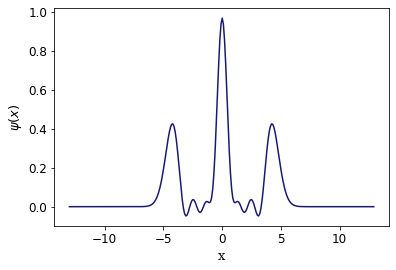

State is normalized: True

S(0.20)(+0.661|0> - 0.343|2> + 0.253|4> - 0.037|6> + 0.377|8> + 0.323|10> + 0.365|12>)


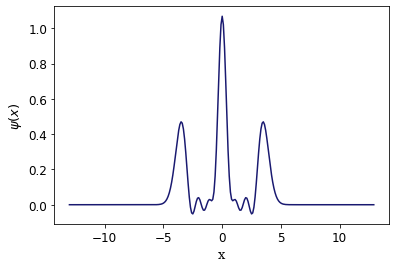

In [69]:
def even_core(c, cutoff=0, draw=False, r_virt=0):
    '''Returns a superposition of even Fock states:

    |psi> = c[0]|0> + c[2]|2> + ... + c[2n]|2n>

    Args:
        c (float): the even Fock state coefficients
        cutoff (int): the Fock basis truncation; will set to the minimal
            sensible truncation and pad with zeros otherwise
        draw (bool): if True, print and plot the state in position
        r_virt: if given, includes initial squeezing S(r_virt) in the string
            and in the wavefunction plot (however does not change the output
            array).

    Returns:
        array: the state |psi>
    '''
    if cutoff < 2 * len(c) - 1:
        cutoff = 2 * len(c) - 1
    # Initialize an array of the right size
    ket = np.zeros([cutoff], dtype=np.complex128)
    # Fill the even slots with coefficients in c.
    ket[0:2*len(c):2] = c
    # Normalize
    norm = np.linalg.norm(ket)
    ket = ket/norm
    # Draw in Dirac notation and plot in position space
    if draw:
        print(fock_str(ket, r_virt))
        x = np.arange(-cutoff, cutoff, 0.1)
        plt.plot(x, np.exp(r_virt/2) * fock_pos(np.exp(r_virt) * x, ket),
                 color='midnightblue', label=fock_str(ket, r_virt))
        plt.xlabel('x', family='serif', size=13)
        plt.ylabel(r'$\psi (x)$', family='serif', size=13)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()
    return ket


def fock_str(ket, r=0):
    '''Returns a string of ket in Dirac notation.'''
    s = ''
    if r:
        s = 'S({:.2f})('.format(r)
    for i in range(len(ket)):
        if i == 0:
            sp = ''
        else:
            sp = ' '
        if ket[i] == 0:
            term = ''
        if np.sign(ket[i]) == 1:
            term = '{}+{}{:.3f}|{}>'.format(sp, sp, abs(ket[i]), i)
        if np.sign(ket[i]) == -1:
            term = '{}-{}{:.3f}|{}>'.format(sp, sp, abs(ket[i]), i)
        s += term
    if r:
        s += ')'
    return s


def n_pos(x, n):
    '''Returns the position wavefunction of the nth Fock state.'''
    return ((1 / np.sqrt(2 ** n * factorial(n))) * (1 / pi ** 0.25) *
            np.exp(- (x ** 2) / 2) * Herm(n)(x))


def fock_pos(x, ket):
    '''The q wavefunction of the Fock superposition describe by ket.'''
    norm = np.linalg.norm(ket)
    return sum([(ket[i]/norm) * n_pos(x, i) for i in range(len(ket))])


# Some tests
if __name__ == '__main__':
    # n changes the nmax in the fock superposition.
    n = 6
    # Example GKP Fock coefficients.
    # np.array([2*round(np.random.rand(), 2)-1 for i in range(n//2 + 1)])
    r, coefs = get_data_pt(gkp_data, 12, 10, 0)
    # Norm of unnormalized states.
    print('Norm:', round(np.linalg.norm(coefs), 5))
    # fock_str writes input in bra-ket notation.
    print('Fock superposition:', fock_str(coefs))
    # even_core assumes input coefficients correspond to even Fock states.
    # draw command plots the state and writes it in bra-ket notation.
    print('Even Fock superposition:')
    state = even_core(coefs, draw=True)
    # Check normalization to precision 10^(-p)
    p = 10
    print('State is normalized:', round(np.linalg.norm(state), p) == 1)
    # Draw with virtual squeezing. Note including r_virt does not modify
    # the actual state array.
    print()
    even_core(coefs, draw=1, r_virt=r)

## Wigner Functions

In [15]:
def wigner_log_negativity(rho, l, cutoff):
    r"""Calculates and returns the Wigner Log Negativity
    of the quantum state:
    .. math:: WLN = \log(\int |W| dx dp)
    Args:
        rho (array): density matrix of the quantum state
        l (float): maximum grid size -x_max < x < x_max
            over which to compute the Wigner function
        cutoff (int): the Fock basis truncation
    Returns:
        float: the Wigner log negativity
    """
    import copy
    x = np.linspace(-l, l, 200)
    p = np.linspace(-l, l, 200)
    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))
    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])
    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi
    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])
    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])
    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)
        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])
        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2
            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])
    return np.log(simps(simps(np.abs(W / 2), p), x))    

def wigner(rho, l=5):
    """This code is a modified version of the ‘iterative’ method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.
    
    All rights reserved."""
    import copy
    # Domain parameter for Wigner function plots
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m)
                    * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

# Some tests
if __name__ == '__main__':
    print()

# Optical circuit

## Circuit helper functions

In [106]:
def to_db(r):
    '''Returns the value of squeezing parameter r in dBs.'''

    return -20 * r / np.log(10)


def init(clip_size):
    '''Generates an initial random parameter.

    Args:
        clip_size (float): the parameter will be clipped
            to the domain [-clip_size, clip_size].

    Returns:
        float: the random clipped parameter.
    '''
    
    return np.random.rand() * 2 * clip_size - clip_size


def random_params(rmax_dB, nmodes):
    ''' Returns a list of random parameters for an nmodes-mode circuit.
    
    Args:
        rmax_dB (float): the maximum squeezing in dBs
        nmodes: the number of modes in the circuit
        
    Returns:
        list: nmodes squeezing parameters followed by 
            nmodes * (nmodes - 1) angles.
    '''
    
    # The squeezing bound.
    clip = abs(to_r(rmax_dB))
    # Put the squeezing and angle bounds into a list.
    bound = [clip] * nmodes + [pi] * nmodes * (nmodes - 1)
    # Randomize
    return list(map(init, bound))


def mode_ceil(nmax):
    '''Return the smallest circuit necessary to produce a state with
    max Fock number nmax with unity fidelity.'''
    
    return int(np.ceil(np.sqrt(2*nmax + 9/4) - 1/2))


def coarse_grainer(nmeas, nmax):
    '''Gives a list of coarse-grainings of measurement patterns.
    
    Assumes nmeas modes are measured, the circuit targets a state
    with a max photon number nmax, and the sum of all the outcomes
    equals nmax. Does not include duplicate measurement patterns, e.g.
    [1, 2, 2] and [2, 2, 1] are considered the same.
    
    Args:
        nmeas (int): the number of measured modes
        nmax (int): the maximum Fock number of the target state
        
    Returns:
        list: a list of lists, each one a unique coarse-graining.
    '''
    if nmeas == 1:
        return [[nmax]]
    res_list = []
    for i in range(1, nmax - nmeas + 2):
        last_list = coarse_grainer(nmeas-1, nmax-i)
        for l in last_list:
            l.insert(0, i)
            l.sort()
            if l not in res_list:
                res_list.append(l)
    return res_list


def even_coarse(nmeas, nmax):
    ''' Return a list of an evenly coarse-grained measurement pattern.
    
    Ensures there are nmax-1 entries in the last, they add to nmax, and
    are as evenly coarse-grained as possible, e.g. for n = 3 and 
    nmax = 5, the list ought to be [2, 2, 3]. 
    
    Args:
        nmodes (int): the number of circuit moes
        nmax (int): the maximum Fock number of the target state
    
    Returns:
        list: the post-selected mesaurement values
    '''
    meas_values = [nmax // (nmeas) for i in range(nmeas - 1)]
    meas_values.append(nmax - sum(meas_values))
    return meas_values


def apply_interferometer(thetas, 
                         phis, 
                         nmodes,
                         q,
                         loss_T=1,
                         conv='sf',
                         final_phis=np.array(0),
                         sketch=False
                        ):
    '''Applies beamsplitters in a rectangular array to the modes of a 
    circuit.
    
    Args:
        thetas (array): the beamsplitter angles
        phis (array): the beamsplitter phases
        nmodes (int): the number of circuit modes
        q (tuple): the circuit modes
        loss_T (float): the loss T parameter
        conv (str): if 'itf', assumes the input thetas and phis are in 
            the interferometer package convention:
                BS_itf(theta, phi) = BS_sf(theta, 0)R(phi)
        final_phis (array): if supplied, applies rotations to
            all modes at the end of the interferometer
        sketch (bool): if True, prints a diagram of the arrangement
            and application
    
    Returns:
        None
    '''
    # The i's are the rows; the j's are the columns; the k's are
    # the parameter indices. The maximum values the indices are taken
    # by observing the pattern in the rectangular decomposition.
    k = 0
    for i in range(nmodes):
        if i % 2 == 0:       
            for j in range(int(np.floor(nmodes/2))):
                # The interferometer package convention
                if conv == 'itf':
                    gate1 = Rgate(phis[k]) 
                    gate2 = BSgate(thetas[k], 0)
                    conv_str = 'Rgate({:.2f}) | q[{}]\n'.format(phis[k], 2*j)
                    conv_phi = 0
                # The Strawberry Fields package convention
                else:
                    gate1 = Rgate(0)
                    gate2 = BSgate(thetas[k], phis[k])
                    conv_str = ''
                    conv_phi = phis[k]
                gate1 | q[2*j]
                gate2 | (q[2*j], q[2*j + 1])
                if (1-loss_T):
                    LossChannel(loss_T) | q[2*j]
                    LossChannel(loss_T) | q[2*j+1]
                if sketch:
                    print(
                        '{}'
                        'BSgate(theta{} = {:.2f}, phi{} = {:.2f})'
                        ' | (q[{}], q[{}])'.format(conv_str, 
                                                   k+1, thetas[k], 
                                                   k+1, conv_phi, 
                                                   2*j, 2*j+1)
                    )
                k += 1
        else:
            for j in range(1, int(np.floor((nmodes-1)/2)) + 1):
                if conv == 'itf':
                    gate1 = Rgate(phis[k]) 
                    gate2 = BSgate(thetas[k], 0)
                    conv_str = 'Rgate({:.2f}) | q[{}]\n'.format(phis[k], 2*j-1)
                    conv_phi = 0
                else:
                    gate1 = Rgate(0)
                    gate2 = BSgate(thetas[k], phis[k])
                    conv_str = ''
                    conv_phi = phis[k]
                gate1 | q[2*j-1]
                gate2 | (q[2*j-1], q[2*j])
                if (1-loss_T):
                    LossChannel(loss_T) | q[2*j-1]
                    LossChannel(loss_T) | q[2*j]
                if sketch:
                    print(
                        '{}'
                        'BSgate(theta{} = {:.2f}, phi{} = {:.2f})'
                        ' | (q[{}], q[{}])'.format(conv_str, 
                                                   k+1, thetas[k], 
                                                   k+1, conv_phi, 
                                                   2*j-1, 2*j)
                    )
                k += 1

    if final_phis.any():
        for i in range(nmodes):
            Rgate(final_phis[i]) | q[i]
            

def optimal_cutoff(p, mu, cov, meas_values, target_dim, tol=1e-3, max_d=100):
    '''Returns the appropriate dimensional cutoff for 
    hafnian.quantum.density_matrix.
    
    This algorithm is based on arXiv:1905.0701, page 3.
    
    Computes ptilde, the trace of the density matrix assuming 
    post-seletion on meas_values and a starting cutoff of target_dim. 
    When 1 - abs(ptilde/p) becomes lower than, returns the cutoff. Else, 
    raises CutoffException.
    
    Args:
        p (float): the exact detection probability
        mu (array): the means of the full rho
        cov (array): the covariance matrix of the full rho
        meas_values (array): the measurement results to post-select on
        target_dim: the dimension of the target state
        tol (int): the tolerance for the difference between p & ptilde
        max_d (int): the cutoff beyond which not to look
    
    Returns:
        int: the appropriate cutoff
    '''
    d = target_dim
    def diag_el(n):
        '''Returns the entry nth diagonal entry of rho.'''
        
        fockvec = meas_values[:]
        fockvec.append(n)
        return density_matrix_element(mu, cov, fockvec, fockvec)
    
    # Find the sum of the first d diagonal entries of rho.
    ptilde = sum([diag_el(i) for i in range(d)]).real
    # Increase d and compare ptilde with p.
    while d < max_d:
#         print(ptilde)
        if 1 - abs(ptilde/p) < tol:
            return d
        ptilde += diag_el(d).real
        d +=1
        
    # At thus point a d less than max_d was not found; print a message
    # and raise an exception.
    s = 'Could not find a cutoff below d = {} with a tolerance of {:.0E}.'
    print(s.format(max_d, tol))
    class CutoffTooHigh(Exception):
        '''Exception used if maximal cutoff is too high.'''
        pass
 
    raise CutoffTooHigh


# Some tests
if __name__ == '__main__':
    # Only nmodes needs to be changed for a new test.
    nmodes = 4
    # The maximum Fock number the circuit can achieve with high fidelity.
    nmax = nmodes * (nmodes + 1) // 2 - 1 
    print('nmax =', nmax)
    # The number of beamsplitters.
    nsplitters = nmodes * (nmodes - 1) // 2
    
    # List of post-selected measurement values.
    meas_values = even_coarse(nmodes-1, nmax)
    print('The measurement pattern is', meas_values)
    
    # Set n = 1 for 1 test. Let n vary to see patterns in the optimal cutoff.
    n = 1
    # A list of optimal cutoffs.
    opt = []
    for j in range(n):
        # Randomize and unpack the circuit parameters.
        x0 = random_params(12, nmodes)
        sq_r = x0[:nmodes]
        thetas = x0[nmodes:nmodes + nsplitters]
        phis = x0[nmodes + nsplitters:]
        prog = sf.Program(nmodes)
        with prog.context as q:
            for i in range(nmodes):
                    Sgate(sq_r[i], 0) | q[i]
            apply_interferometer(thetas, 
                                 phis, 
                                 nmodes, 
                                 q,
                                 sketch=0)
        start = time()
        eng = sf.Engine('gaussian')
        state = eng.run(prog).state
        mu, cov = state.means(), state.cov()
        mu_r, cov_r = state.reduced_gaussian(list(range(nmodes-1)))
        p = density_matrix_element(mu_r, cov_r, meas_values, meas_values).real
#         print('p=', p)
        d = optimal_cutoff(p, mu, cov, meas_values, 1)
#         print(j,':', d)
        opt.append(d)
        end = time()
#         print(end - start)

    print('\nMin cutoff is', min(opt))
    print('Max cutoff is', max(opt))
    print('Average cutoff is', sum(opt) / n)

    # Check to see if exception is raised.
#     optimal_cutoff(eng, meas_values, 1, max_d=1)

    # Check to see if the last element of the output list pf coarse_grainer is
    # the even coarse-graining.
    coarsever = []
    for nmeas in range(1, 4):
        for nmax in range(1, 50):
            if nmax % nmeas == 0:
                coarsever.append(even_coarse(nmeas, nmax) 
                                 == coarse_grainer(nmeas, nmax)[-1])
    print(all(coarsever))

nmax = 9
The measurement pattern is [3, 3, 3]

Min cutoff is 14
Max cutoff is 14
Average cutoff is 14.0
True


## The circuit function

In [17]:
for n_index in [12]:
    for mode_index in range(3, 4):
        for cg in [[5,7]]:
            for delta in [10]:
                m_str = '&'.join([str(outcome) for outcome in cg])
                res_str = ('(nmax={})(nmodes={})(pattern={})(delta={})'
                                   ''.format(n_index, mode_index, m_str, delta))
                data = pickle.load(open('paper_data\\' + res_str + '.pickle', 'rb'))
                print(res_str)
                print(data[1],to_db(data[0][:mode_index]))

(nmax=12)(nmodes=3)(pattern=5&7)(delta=10)
[0.996774441557795, 0.0010637838420326127] [12.         10.57069004 -6.77396638]


Testing exceptions:
Please ensure that you have specified 4 squeezing parameters followed by 12 beam splitter parameters.

Please ensure that the number of post-selected modes is one fewer than the number of circuit modes.

 + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +
This 3-mode circuit targets the state

S(0.00)(+0.629|0> - 0.332|2> + 0.404|4> + 0.159|6> + 0.553|8>)


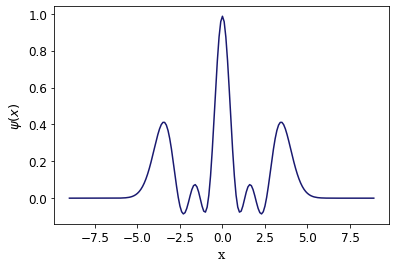


        Post-selection on measurements of the first 2 modes, and the target 
        state emerges in the last mode. Squeezing gates applied to every mode 
        at the beginning with no squeezing phases and no displacements; this is 
        followed by the most general rectangular decomposition in 3 modes
        (minus terminal phases), as follows:
        

BSgate(theta1 = 0.57, phi1 = 3.14) | (q[0], q[1])
BSgate(theta2 = 0.91, phi2 = -1.57) | (q[1], q[2])
BSgate(theta3 = 0.79, phi3 = 1.57) | (q[0], q[1])

The fidelity to the target state is 0.9985 and the probability is 0.0041. The optimal Fock cutoff is 9.


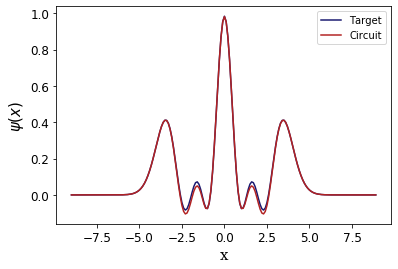

 + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +
This 3-mode circuit targets the state

+0.629|0> - 0.332|2> + 0.404|4> + 0.159|6> + 0.553|8>


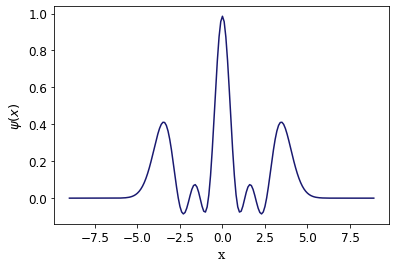


        Post-selection on measurements of the first 2 modes, and the target 
        state emerges in the last mode. Squeezing gates applied to every mode 
        at the beginning with no squeezing phases and no displacements; this is 
        followed by the most general rectangular decomposition in 3 modes
        (minus terminal phases), as follows:
        

BSgate(theta1 = 0.57, phi1 = 3.14) | (q[0], q[1])
BSgate(theta2 = 0.91, phi2 = -1.57) | (q[1], q[2])
BSgate(theta3 = 0.79, phi3 = 1.57) | (q[0], q[1])

The fidelity to the target state is 0.6493 and the probability is 0.0033. The optimal Fock cutoff is 12.


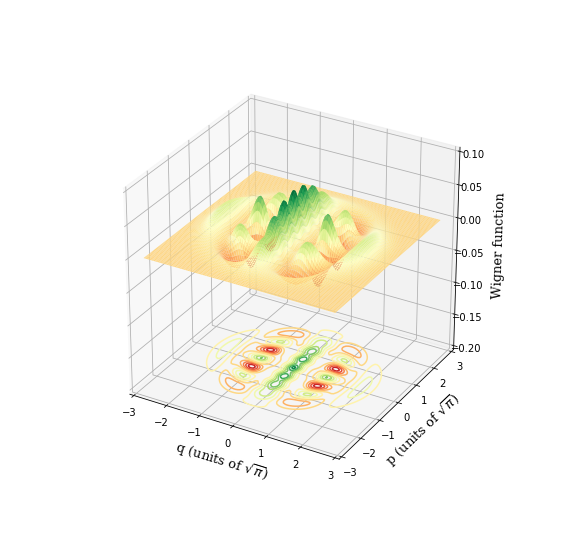

The Wigner log negativity is 0.4393.


In [136]:
engine_time = 0
hafnian_time = 0

def fock_circuit(params, 
                 target, 
                 post_m, 
                 nmodes, 
                 loss_Ts=np.array([1,1,1,1]),
                 give_rho=False, 
                 give_neg=False,
                 specs=False,
                 r_final=0,
                 r_virt=0, 
                 U_itf=np.array(0), 
                 conv='sf', 
                 final_phis=np.array(0)):
    '''Runs a constrained variational circuit with specified 
    parameters to generate a Fock superposition in the final mode.
    
    Assumes the circuit squeezes the target states and sends them 
    through an interferometer in a rectangular arrangement. No squeezing
    phases or displacements. Returns the output fidelity to the 
    target state target in the Fock basis, as well as the post-selection 
    probability of the state produced by the circuit. If give_rho is 
    True, also computes the optimal cutoff of the Fock state and 
    provides the state.

    Args:
        params (list): list of gate parameters for the constrained
            variational quantum circuit, with nmodes modes.
            
            This should contain the following values in the following 
            order:

            * sq_r0, sq_r1, ..., sq_n: the squeezing magnitudes applied 
                to all the modes
            * bs_theta1, bs_theta2, ..., bs_theta[n*(n-1)]/2: the 
                beamsplitter angles theta
            * bs_phi1, bs_phi2, ..., bs_theta[n*(n-1)]/2: the 
                beamsplitter phases phi

        target (array): the Fock coefficients of the target state
        post_m (list): the Fock state measurement outcomes to be 
            post-selected; post_m[i] correpsonds to the ith mode
        nmodes (int): the number of circuit modes
        loss_Ts (array): the loss T parameters (transmissivities). 
            1 corresponds to no loss. Assumes:
            loss_Ts[0]: loss at initial squeezers;
            loss_Ts[1]: loss at interferometer;
            loss_Ts[2]: coupling loss;
            loss_Ts[3]: loss at PNRs
        give_rho (bool): if True, returns the state produced by the 
            circuit.
        give_neg (bool): if True, computes and returns the Wigner 
            log negativity of the output state. None that if give_rho is 
            False, the negativity is found without a computation optimal 
            cutoff,so it will deviate from the true value. However this 
            will speed up optimizations where the cost functions involve 
            the negativity
        specs (bool): if True, prints circuit properties and plots 
            graphs: if no losses, gives the position wavefunctions; if 
            there are losses, gives a visual representation of the 
            density operator or the Wigner functions if give_neg is True
        r_final (float): a final squeezing to apply to the last mode
            of the circuit.
        r_virt (float): the squeezing parameter; given to produce a plot 
            of the full target state, i.e., the squeezed core, and to 
            compute fidelities if give_rho specified. Equal to r_final
            if r_final given.
        U_itf (array): if supplied, applies U_itf after the squeezing 
            gates instead of the rectangular interferometer
        conv (str): if 'itf', assumes the parameters are in the 
            interferometer package convetion: 
            BS_itf(theta, phi) = BS_sf(theta, 0)R(phi)
        final_phis (array): if supplied, applies rotations to
            all modes at the end of the interferometer

    Returns:
        tuple: the output fidelity to the target GKP state and the 
            probability of post-selection; if give_rho is True,
            also gives the density matrix of the produced state
            and the optimal cutoff.
    '''
    # Verify correct sizes of input parameters.
    if nmodes != len(post_m) + 1:
        print('Please ensure that the number of post-selected modes is one '
              'fewer than the number of circuit modes.')
        class ModeNumberException(Exception):
            pass
        raise ModeNumberException
    
    nsplitters = nmodes * (nmodes - 1) // 2
    
    if len(params) != 2 * nsplitters + nmodes:
        print('Please ensure that you have specified {} squeezing parameters ' 
              'followed by {} beam splitter parameters.'
              ''.format(nmodes, 2 * nsplitters))
        class ParameterNumberException(Exception):
            pass
        raise ParameterNumberException
        
    if r_final:
        r_virt = r_final
    
    # Dimension of the target state.
    target_dim = len(target)
   
    # Used to evaluate the total time for the density_matrix function.
    global hafnian_time
    global engine_time
    
    sketch = 0
    # Describes the circuit.
    if specs:
        sketch = 1
        print('This {}-mode circuit targets the state'
              '\n'.format(nmodes))
        even_core(target[::2], draw=True, r_virt=r_virt)
        print('''
        Post-selection on measurements of the first {} modes, and the target 
        state emerges in the last mode. Squeezing gates applied to every mode 
        at the beginning with no squeezing phases and no displacements; this is 
        followed by the most general rectangular decomposition in {} modes
        (minus terminal phases), as follows:
        \n'''.format(nmodes-1, nmodes))
                                                                                                                                            
    # Unpack the circuit parameters
    # Squeezing r's
    sq_r = params[:nmodes]
    # Beamsplitter theta's
    bs_thetas = params[nmodes:nmodes + nsplitters]
    # Beamsplitter phi's
    bs_phis = params[nmodes + nsplitters:]

    # Run the engine
    prog = sf.Program(nmodes)
    eng = sf.Engine('gaussian')
    with prog.context as q:
        for k in range(nmodes):
            Sgate(sq_r[k], 0) | q[k]
            if (1-loss_Ts).any():
                LossChannel(loss_Ts[0]) | q[k]
        if U_itf.any():
            Interferometer(U_itf) | q
        else:
            apply_interferometer(bs_thetas, 
                                 bs_phis, 
                                 nmodes, 
                                 q,
                                 loss_T=loss_Ts[1],
                                 conv=conv,
                                 final_phis=final_phis, 
                                 sketch=sketch)
        if (1-loss_Ts).any():
            for k in range(nmodes):
                LossChannel(loss_Ts[2]) | q[k]
                if k != nmodes-1:
                    LossChannel(loss_Ts[3]) | q[k]
            
        Sgate(r_final) | q[nmodes-1]

    # Extract the state, means, and covariances.
    start = time()
    state = eng.run(prog).state
    mu, cov = state.means(), state.cov()
    end = time()
    engine_time += end - start
    start = time()
    mu_r, cov_r = state.reduced_gaussian(list(range(nmodes-1)))
    prob = density_matrix_element(mu_r, cov_r, post_m, post_m).real
    
    # Dictionary of post-selected measurement outcomes.
    postdict = {i: post_m[i] for i in range(nmodes-1)}
    if (1-loss_Ts).any():
        rho = density_matrix(mu, cov, post_select=postdict, cutoff=target_dim)
    else:
        rho = state_vector(mu, cov, post_select=postdict, cutoff=target_dim)
    end = time()
    hafnian_time += end - start

    # Normalize the output state
    if prob < 1e-15:
        if give_neg:
            return 0, 0, 0
        else:
            return 0, 0
    if (1-loss_Ts).any():
        rho = rho / prob
        fidelity = np.abs(np.conj(target).dot(rho).dot(target))
        p_outside = 1 - np.trace(rho).real
    else:
        rho = rho / np.sqrt(prob)
        fidelity = np.abs(np.conj(target).dot(rho)) ** 2
        p_outside = 1 - (np.conj(rho).dot(rho)).real

    # Compute the optimal cutoff and give the output state if this is 
    # requested.
    if give_rho:
        start = time()
        d = optimal_cutoff(prob, mu, cov, post_m, 1)
        if d < target_dim:
            d = target_dim
        # The target density operator padded with 0s.
        targ_p = np.append(target[:], [0 for i in range(d - target_dim)])
        prog = sf.Program(1)
        eng = sf.Engine('fock', backend_options={'cutoff_dim':d})
        with prog.context as q:
            Ket(targ_p) | q[0]
            Sgate(r_virt) | q[0]
        target = eng.run(prog).state.ket()
        target = target / np.linalg.norm(target)
        if (1-loss_Ts).any():
            rho = density_matrix(mu, cov, post_select=postdict, cutoff=d)
            rho = rho / prob
            rho = rho * np.exp(np.angle(target[0]/rho[0,0])*1j)
            fid = np.abs(np.conj(target).dot(rho).dot(target))
        else:
            rho = state_vector(mu, cov, post_select=postdict, cutoff=d)
            rho = rho / np.sqrt(prob)
            rho = rho * np.exp(np.angle(target[0]/rho[0])*1j)
            # Fidelity with the target
            fid = np.abs(np.conj(target).dot(rho)) ** 2
        # Print and visualize results.
        if specs:
            print('\n'
              'The fidelity to the target state is {:.4f} and the probability'
              ' is {:.4f}. The optimal Fock cutoff is {}.'.format(fid, prob, d)
                 )
            if give_neg:
                if len(rho.shape) == 1:
                    rho = np.outer(rho, np.conj(rho))
                neg = wigner_log_negativity(rho, 1.5*d, d)
                fig = plt.figure()
                fig.set_figwidth(10)
                fig.set_figheight(10)
                ax = fig.add_subplot(111, projection="3d")
                X, P, W = wigner(rho, l=7)
                X = np.exp(-r_virt)*X/np.sqrt(2*np.pi)
                P = np.exp(r_virt)*P/np.sqrt(2*np.pi)
                ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, 
                                cstride=1)
                ax.contour(X, P, W, 12, cmap="RdYlGn", linestyles="solid", 
                           offset=-0.2)
                ax.set_xlim3d(-3,3)
                ax.set_ylim3d(-3,3)
                ax.set_zlim3d(-0.2, 0.1)
                ax.set_xlabel('\n q '+r'(units of $\sqrt{\pi}$)', 
                              family='serif', size = 13)
                ax.set_ylabel('\n p '+r'(units of $\sqrt{\pi}$)', 
                              family='serif', size = 13)
                ax.set_zlabel('\n\n Wigner function', 
                              family='serif', size = 13)
                ax.dist = 13
                plt.show()
                print('The Wigner log negativity is {:.4f}.'.format(neg))
            elif (1-loss_Ts).any():
                fig = plt.figure()
                ax1 = fig.add_subplot(1, 2, 1)
                ax1.imshow(rho.real)
                ax1.set_xlabel(r'Real part of $\rho$', family='serif', size=13)
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.imshow(rho.imag)
                ax2.set_xlabel(r'Imaginary part of $\rho$', family='serif',
                               size=13)
                plt.show()
            else:
                x = np.arange(-target_dim, target_dim, 0.1)
                plt.plot(x, fock_pos(x, target), label='Target', 
                         color='midnightblue')
                plt.plot(x, fock_pos(x, rho), label='Circuit', 
                         color='firebrick')
                plt.xlabel('x', family='serif', size='15')
                plt.ylabel(r'$\psi (x)$', size='15')
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.legend()
                plt.show()
        return fid, prob, rho, d
    
    else:
        if specs:
            print('\n'
                  'The fidelity to the target state is {:.4f} and the'
                  ' probability is {:.4f}'.format(fidelity, prob))
        if give_neg:
            rho = np.outer(rho, np.conj(rho))
            neg = wigner_log_negativity(rho, target_dim, target_dim)
            if specs:
                print(
                '''
                The Wigner log negativity is {:.3f}. Note that this value is 
                calculated before the computation of the optimal fock cutoff. 
                Because the {:.3f} of the state lies outside of this cutoff, 
                the true value of negativity will be different. To obtain the 
                real value, please set give_rho to True.
                '''.format(neg, p_outside)
                )
            return fidelity, prob, neg
        else:
            return fidelity, prob

# Some tests
if __name__ == '__main__':

#     c = [0.947,-0.282, 0.147, 0.015, 0.052]
    r,c = get_data_pt(gkp_data,8,10,0)#[1, 1, 1]
    target = even_core(c)
    
    # Ensure wrong sizes of input parameter lists are correctly dealt with.
    print('Testing exceptions:')
    try:
        nmodes = 4
        post_m = [2,2,2]
        params = random_params(12, nmodes-1)
        fock_circuit(params, target, post_m, nmodes)
        print()     
   
    except Exception:
        print()
  
    try:
        nmodes = 3
        post_m = even_coarse(nmodes, 4)
        fock_circuit(params, target, post_m, nmodes)
        print()
        
    except Exception:
        print()

    print(50 * ' +')
    
    nmodes = 3
    params = get_circuit_data_pt(8,3,[4,4],10)#random_params(12, nmodes)
    post_m = [4,4]#even_coarse(nmodes-1, 12)

#     fock_circuit(params, target, post_m, nmodes, give_rho=True, specs=1, 
#                 conv='itf')
    fock_circuit(params, target, post_m, nmodes, give_rho=True, 
                 r_virt=r, r_final=r, specs=True)
    
    print(50 * ' +')

    # Test lossy circuit.
    losses_dB = -np.array([0.06, 0.06, 0.06, 0.06])
#     No loss sanity check
#     losses_dB = np.zeros(4)
    losses = 10**(losses_dB/10)
    fock_circuit(params, target, post_m, nmodes, 
                 loss_Ts=losses, 
                 give_rho=True,
                 give_neg=True,
                 specs=True)


# Optimization

## The global optimization

Start time:  2020-02-04 16:17:16.853443
:::::::::::::::::::::::::::::::::::::::::::::::
Basin hopping: global search for high fidelity
:::::::::::::::::::::::::::::::::::::::::::::::

Optimizing a 3-mode circuit for target state

+0.707|0> + 0.707|2>


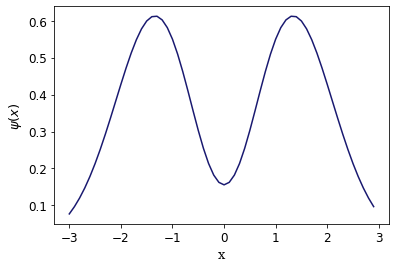


with measurement pattern [1, 1] of the first 2 modes.
Basin hopping called with 50 iterations and max of 1000 iterations for minimize.

Hop 1 fidelity: 0.82060, prob: 1.712e-01
Hop 2 fidelity: 0.82058, prob: 1.713e-01
Hop 3 fidelity: 0.81173, prob: 2.500e-01
Hop 4 fidelity: 0.81173, prob: 2.500e-01
Hop 5 fidelity: 0.82052, prob: 1.712e-01
Hop 6 fidelity: 0.82057, prob: 1.714e-01


KeyboardInterrupt: 

In [53]:
hafnian_time = 0
engine_time = 0


def global_cost(params, target, post_m, nmodes,
                loss_Ts=np.array([1, 1, 1, 1]), give_neg=False):
    '''Returns the global cost function of the constrained variational circuit.

    The cost function is given by:

        cost = -fidelity -0.1*prob

    Therefore, minimising the cost function will result in the output 
    state approaching the target state.

    Args:
        params (list): list of gate parameters for the constrained
            variational quantum circuit, with nmodes modes.

            This should contain the following values in the following 
            order:

            * sq_r0, sq_r1, ..., sq_n: the squeezing magnitudes applied 
                to all the modes
            * bs_theta1, bs_theta2, ..., bs_theta[n*(n-1)]/2: the 
                beamsplitter angles theta
            * bs_phi1, bs_phi2, ..., bs_theta[n*(n-1)]/2: the 
                beamsplitter phases phi

        c (float): the coefficients of the Fock expansion of the 
            approximate GKP state
        r_target (float): the squeezing of the target Fock expansion
        post_m (list): the Fock state measurement outcomes to be 
            post-selected; post_m[i] correpsonds to the ith mode
        nmodes (int): the number of circuit modes
        loss_Ts (array): the loss T parameters (transmissivities). 
            1 corresponds to no loss. Assumes:
            loss_Ts[0]: loss at initial squeezers;
            loss_Ts[1]: loss at interferometer;
            loss_Ts[2]: coupling loss;
            loss_Ts[3]: loss at PNRs
        give_neg (bool): if True, computes the Wigner log negativity
            of state output by the circuit should the cost function 
            require it.

    Returns:
        float: cost value.
    '''
    if give_neg:
        fidelity, prob, neg = fock_circuit(params, target, post_m, nmodes,
                                           loss_Ts=loss_Ts, give_neg=True)
    else:
        fidelity, prob = fock_circuit(params, target, post_m, nmodes,
                                      loss_Ts=loss_Ts)

#     print("Iteration fidelity = {}".format(fidelity))
    cost = - fidelity - 0.1*prob
    return cost


# The index of the fidelity steps for the local and global optimization.
fidelity_index_2 = 0
# The fidelity and probability dump lists for the global optimizaiton.
fid_progress = []
prob_progress = []


class stopException(Exception):
    '''Exception used if the optimization is stopped.'''
    pass


def run_global_optimization(target, post_m, nmodes,
                            loss_Ts=np.array([1, 1, 1, 1]),
                            init_guess=None,
                            give_neg=False,
                            niter=50,
                            max_iter=1000,
                            direc='test_data\\',
                            save=False):
    '''Run the constrained variational quantum circuit global 
    optimization using the basin hopping algorithm.

    Args:
        target (array): the Fock coefficients of the target state
        post_m (list): the Fock state measurement outcomes to be 
            post-selected; post_m[i] correpsonds to the ith mode
        loss_Ts (array): the loss T parameters (transmissivities). 
            1 corresponds to no loss. Assumes:
            loss_Ts[0]: loss at initial squeezers;
            loss_Ts[1]: loss at interferometer;
            loss_Ts[2]: coupling loss;
            loss_Ts[3]: loss at PNRs
        nmodes (int): the number of modes of the circuit
        init_guess (array): supplies the initial guess to the 
            optimization; if None, randomizes the guess
        give_neg (bool): if True, computes the Wigner log negativity for
            cost functions that require it
        niter (int): the number of hops in basinhopping
        max_iter (int): the maximum number of iterations for minimize
        direc (str): data directory to save output
        save (bool): if True, save the output in directory direc

    Returns:
        tuple: optimization results. A tuple of circuit parameters,
            fidelity to the target state, and probability of generating 
            the state.
    '''

    # Generate the initial random parameters and bounds.
    # Maximum squeezing in dB to search through.
    clip = 15
    if init_guess:
        x0 = init_guess
    else:
        x0 = random_params(clip, nmodes)
    # Beamsplitter parameters go from -pi to pi.
    lims = [(-to_r(clip), to_r(clip))] * nmodes +\
        [(-pi, pi)] * nmodes * (nmodes - 1)
    # Perform the optimization
    minimizer_kwargs = {'method': 'SLSQP',  # or L-BFGS-B
                        'args': (target, post_m, nmodes, loss_Ts, give_neg),
                        'options': {'maxiter': max_iter},
                        'bounds': lims}

    def myAccept(xk, f, accepted):
        '''This accept condition is to save some computational time 
        which is optional.'''

        global fidelity_index_2
        global fid_progress
        global prob_progress
        fidelity_index_2 += 1
        fidelity, prob = fock_circuit(xk, target, post_m, nmodes,
                                      loss_Ts=loss_Ts)
        fid_progress.append(fidelity)
        prob_progress.append(prob)

        print('Hop {} fidelity: {:.5f}, prob: {:.3e}'
              ''.format(fidelity_index_2, fidelity, prob))

        if fidelity >= .9999 and prob >= 1e-3:
            file_name = direc
            results = {'para': xk,
                       'fid_progress': fid_progress,
                       'prob_progress': prob_progress}
#             with open(file_name + '.pickle', 'wb') as handle:
#                 pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

            time_elapsed = time() - start
            print('\n Sufficient solution found early.')
            return True

    print('Optimizing a {}-mode circuit for target state\n'.format(nmodes))
    # This is here so that the GKP state is printed.
    even_core(target[::2], draw=1)
    print('\nwith measurement pattern {} of the first {} modes.\nBasin hopping'
          ' called with {} iterations and max of {} iterations for minimize.'
          '\n'.format(post_m, nmodes-1, niter, max_iter))
    res = basinhopping(global_cost, x0, minimizer_kwargs=minimizer_kwargs,
                       niter=niter, callback=myAccept)

    fid, prob = fock_circuit(res.x, target, post_m, nmodes, loss_Ts=loss_Ts)

    if save:
        # For shorter file string, take the real part of the coefficients.
        c_str = '&'.join(['{:.3f}'.format(coef.real) for coef in target])
        m_str = '&'.join([str(outcome) for outcome in post_m])
        res_str = ('global(nmodes={})(c={})(pattern={})'
                   ''.format(nmodes, c_str, m_str))
        out_file_name = (direc + res_str + '.pickle')
        with open(out_file_name, 'wb') as handle:
            pickle.dump([res.x, [fid, prob]], handle, protocol=-1)
        print('\nSaved to ' + out_file_name)

    print('\n The optimal fidelity is {:.5f}, with probability {:.5f}'.format(
        fid, prob))

    return res.x, fid, prob


if __name__ == '__main__':
    # Number of circuit modes.
    nmodes = 3
    # Core state
    c = [1, 1]
#     r, c = get_data_pt(gkp_data, 12, 10, 0)
    target = even_core(c)
    # Measurement pattern.
    post_m = even_coarse(nmodes-1, len(target)-1)

    print('Start time: ', datetime.now())
    print(':::::::::::::::::::::::::::::::::::::::::::::::')
    print('Basin hopping: global search for high fidelity')
    print(':::::::::::::::::::::::::::::::::::::::::::::::\n')

    start = time()
    losses_dB = -np.array([0.1, 0.1, 0.1, 0.1])
    losses_dB = np.zeros(4)
    losses = 10 ** (losses_dB/10)
    x0, _, _ = run_global_optimization(target, post_m, nmodes,
                                       niter=50,
                                       loss_Ts=losses,
                                       give_neg=False,
                                       save=True,
                                       direc="test_data\\")
    time_elapsed = time() - start

    print('\n Runtime: {:.3f} seconds'.format(time_elapsed),
          '\n Total Walrus time: {:.3f} seconds'.format(hafnian_time),
          '\n Total StrawberryFields time: {:.3f} seconds'.format(engine_time))

## The local opimization

In [26]:
# List for the parameters for the local optimization.
xf = []

def local_cost(params, target, post_m, nmodes,
              loss_Ts=np.array([1,1,1,1])):
    '''Returns the local cost function of the constrained variational circuit.

    The cost function is given by:

        cost = - fidelity - prob

    Therefore, minimising the cost function will result in the output 
    state approaching the target state with a higher probability.

    Args:
        params (list): list of gate parameters for the constrained
            variational quantum circuit, with nmodes modes.
            
            This should contain the following values in the following 
            order:

            * sq_r0, sq_r1, ..., sq_n: the squeezing magnitudes applied 
                to all the modes
            * bs_theta1, bs_theta2, ..., bs_theta[n*(n-1)]/2: the 
                beamsplitter angles theta
            * bs_phi1, bs_phi2, ..., bs_theta[n*(n-1)]/2: the 
                beamsplitter phases phi

        c (float): the coefficients of the Fock expansion of the 
            approximate GKP state
        r_target (float): the squeezing of the target Fock expansion
        post_m (list): the Fock state measurement outcomes to be 
            post-selected; post_m[i] correpsonds to the ith mode
        nmodes (int): the number of circuit modes
        loss_Ts (array): the loss T parameters (transmissivities). 
            1 corresponds to no loss. Assumes:
            loss_Ts[0]: loss at initial squeezers;
            loss_Ts[1]: loss at interferometer;
            loss_Ts[2]: coupling loss;
            loss_Ts[3]: loss at PNRs

    Returns:
        float: cost value.
    '''
    fidelity, prob = fock_circuit(params, target, post_m, nmodes, loss_Ts)
#     print("Iteration fidelity = {}".format(fidelity))
    cost = - fidelity - prob
    return cost


def run_local_optimization(target, post_m, nmodes, init_params,
                           loss_Ts=np.array([1,1,1,1]),
                           init_guess=None,
                           direc='test_data\\', save=False):
    '''Run the constrained variational quantum circuit local 
    optimization using the basin hopping algorithm.

    Args:
        target (array): the Fock coefficients of the target state
        post_m (list): the Fock state measurement outcomes to be 
            post-selected; post_m[i] correpsonds to the ith mode
        nmodes (int): the number of modes of the circuit
        init_guess (array): supplies the initial guess to the 
            optimization; if None, randomizes the guess
        init_params (Sequence): initial gate parameters
        direc (str): data directory to save output
        loss_Ts (array): the loss T parameters (transmissivities). 
            1 corresponds to no loss. Assumes:
            loss_Ts[0]: loss at initial squeezers;
            loss_Ts[1]: loss at interferometer;
            loss_Ts[2]: coupling loss;
            loss_Ts[3]: loss at PNRs
        save (bool): if True, save the output in directory direc

    Returns:
        tuple: optimization results. A tuple of circuit parameters,
            fidelity to the target state, and probability of generating 
            the state.
    '''

    def printfunc(xk):
        '''Callback print function for the BFGS minimization algorithm.'''
        
        global fidelity_index
        global xf
        fidelity_index +=1
        fidelity, prob = fock_circuit(xk, target, post_m, nmodes,
                                     loss_Ts=loss_Ts)

        xf = xk
        print("Step {} fidelity: {:.5f}, probability: {:.3e}".format(
            fidelity_index, fidelity, prob))
        #if  fidelity >= 0.90434 and prob >= 0.158071:
        #    raise stopException()

    # Run optimization
    args = (target, post_m, nmodes, loss_Ts)
    #try:
    res = minimize(local_cost, init_params, args=args, method='BFGS', 
                   callback=printfunc, options={'gtol': 1e-4, 
                                                'maxiter':1000})
    #Except stopException:

    fid, prob = fock_circuit(xf, target, post_m, nmodes, loss_Ts=loss_Ts)
    if save:
        # For shorter file string, take the real part of the coefficients.
        c_str = '&'.join(['{:.3f}'.format(coef.real) for coef in target])
        m_str = '&'.join([str(outcome) for outcome in post_m])
        res_str = ('local(nmodes={})(c={})(pattern={})'
                               ''.format(nmodes,c_str, m_str))
        out_file_name = direc + res_str + '.pickle'
        with open(out_file_name, 'wb') as handle:
            pickle.dump([xf, [fid, prob]], handle, protocol=-1)
        print('\nSaved to ' + out_file_name)
        
    print("\nFinal fidelity: {:.5f}, probability: {:.2e}.".format(fid, prob)) 
    return res.x, fid, prob


if __name__ == '__main__':
    start = time()
    print(datetime.now())
    print('::::::::::::::::::::::::::::::::::')
    print('Local search for high probability')
    print('::::::::::::::::::::::::::::::::::\n')
    fidelity_index = 0
    xf = []
    run_local_optimization(target, post_m, nmodes, x0,
                           loss_Ts=losses,
                           save=1, direc='test_data\\')
    print('Run time: {:.3f} seconds.'.format(time()-start))

2020-02-04 15:57:50.148362
::::::::::::::::::::::::::::::::::
Local search for high probability
::::::::::::::::::::::::::::::::::

Step 1 fidelity: 0.99962, probability: 1.011e-01
Step 2 fidelity: 0.99945, probability: 1.018e-01
Step 3 fidelity: 0.99832, probability: 1.035e-01
Step 4 fidelity: 0.99828, probability: 1.035e-01
Step 5 fidelity: 0.99825, probability: 1.036e-01
Step 6 fidelity: 0.99829, probability: 1.035e-01
Step 7 fidelity: 0.99833, probability: 1.035e-01
Step 8 fidelity: 0.99836, probability: 1.035e-01
Step 9 fidelity: 0.99837, probability: 1.035e-01
Step 10 fidelity: 0.99835, probability: 1.035e-01
Step 11 fidelity: 0.99833, probability: 1.035e-01
Step 12 fidelity: 0.99833, probability: 1.035e-01

Saved to test_data\local(nmodes=3)(c=0.707&0.000&0.707)(pattern=1&1).pickle

Final fidelity: 0.99833, probability: 1.04e-01.
Run time: 0.837 seconds.


## Optimal circuits for Approximate GKP states

Start time:  2020-02-04 15:58:21.495227
::::::::::::::::::::::::::::::::::::::::::::::
Basin hopping: global search for high fidelity
:::::::::::::::::::::::::::::::::::::::::::::: 
Target squeezing Delta = 3
Optimizing a 2-mode circuit for target state

-0.975|0> + 0.201|2> - 0.079|4> - 0.022|6> - 0.039|8> - 0.019|10> - 0.006|12>


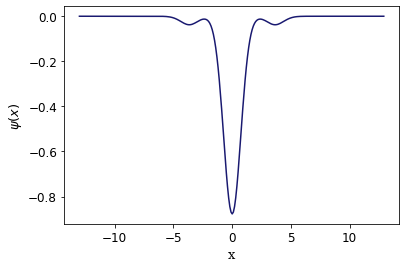


with measurement pattern [12] of the first 1 modes.
Basin hopping called with 5 iterations and max of 1000 iterations for minimize.

Hop 1 fidelity: 0.99636, prob: 1.723e-06
Hop 2 fidelity: 0.99634, prob: 3.640e-02
Hop 3 fidelity: 0.99634, prob: 3.640e-02


KeyboardInterrupt: 

In [27]:
if __name__ == '__main__':
    engine_time = 0
    hafnian_time = 0
    D_vals = gkp_data.index.levels[1].values

    fid = np.zeros((len(D_vals)))
    prob = np.zeros((len(D_vals)))

    start_all = time()

    for n_index in range(12, 32, 2):
        for mode_index in range(2, mode_ceil(n_index) + 1):
            for cg in coarse_grainer(mode_index-1, n_index):
                for delta in D_vals.astype(int):
                    try:
                        fidelity_index_1 = 0
                        fidelity_index_2 = 0
                        c = -get_data_pt(gkp_data, n_index, delta, 0)[1]
                        target = even_core(c)
                        
                        losses_dB = np.zeros(4)
#                         losses_dB = -np.array([0.1, 0.1, 0.1, 0.1])
                        losses = 10**(losses_dB/10)

                        print('Start time: ', datetime.now())
                        print('::::::::::::::::::::::::::::::::::::::::::::::')
                        print('Basin hopping: global search for high fidelity')
                        print('::::::::::::::::::::::::::::::::::::::::::::::',
                             '\nTarget squeezing Delta = ' + str(delta))

                        start = time()
                        x0, fglob, pglob = run_global_optimization(
                            target, cg, mode_index, niter=5, loss_Ts=losses
                        )

                        time_elapsed = time() - start

                        print('\n Runtime: {:.3f}'
                              ' seconds'.format(time_elapsed), 
                              '\n Total Walrus time: {:.3f}' 
                              ' seconds'.format(hafnian_time),
                              '\n Total StrawberryFields time: {:.3f}' 
                              ' seconds'.format(engine_time),
                              '\n')

                        start = time()
                        print(datetime.now())
                        print('::::::::::::::::::::::::::::::::::')
                        print('Local search for high probability')
                        print('::::::::::::::::::::::::::::::::::\n')

                        _, f, p = run_local_optimization(
                            target, cg, mode_index, x0)

                        c_str = '&'.join(['{:.3f}'.format(coef) for coef in c])
                        m_str = '&'.join([str(outcome) for outcome in cg])
                        res_str = ('(nmax={})(nmodes={})(pattern={})(delta={})'
                                   ''.format(n_index, 
                                             mode_index,
                                             m_str, 
                                             delta))
                        
                        with open('test_data\\' +
                                  res_str + 
                                  '.pickle', 'wb') as handle:
                            pickle.dump(np.array([[xf, f, p], 
                                                  [x0, fglob, pglob]]), 
                                        handle, protocol=-1)
                            
                        print('\nSaved to ' + '\test_data\\' + res_str + '.pickle')

                        print('\n'
                              'Use time {:.3f} seconds.'
                              '\n'.format(time() - start))

                    except Exception:
                        print('Problem for nmax = {}, nmodes = {}, delta = {},'
                              ' pattern = {}'.format(n_index, 
                                                   mode_index, 
                                                   delta, 
                                                   cg))
                        traceback.print_exc()

    print('Total runtime:', time() -  start_all)

## Verify ouput

This 3-mode circuit targets the state

-0.661|0> + 0.343|2> - 0.253|4> + 0.037|6> - 0.377|8> - 0.323|10> - 0.365|12>


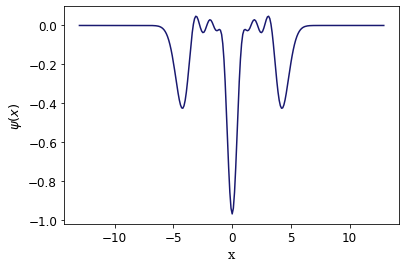


        Post-selection on measurements of the first 2 modes, and the target 
        state emerges in the last mode. Squeezing gates applied to every mode 
        at the beginning with no squeezing phases and no displacements; this is 
        followed by the most general rectangular decomposition in 3 modes
        (minus terminal phases), as follows:
        

BSgate(theta1 = 1.04, phi1 = 1.48) | (q[0], q[1])
BSgate(theta2 = 0.88, phi2 = 1.70) | (q[1], q[2])
BSgate(theta3 = 0.90, phi3 = -0.24) | (q[0], q[1])

The fidelity to the target state is 0.4490 and the probability is 0.0008. The optimal Fock cutoff is 15.


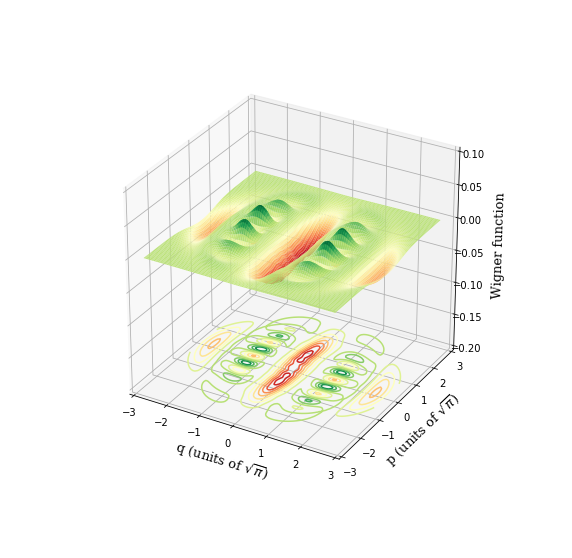

The Wigner log negativity is 0.2474.
Optimal fidelity = 0.99677


In [75]:
if __name__ == '__main__':
    # Verify that the circuit produces the right state with the optimal parameters.
    nmax = 12
    nmodes = 3
    delta = 10
    cg = even_coarse(nmodes - 1, nmax)
    cg = [5, 7]
    m_str = '&'.join([str(outcome) for outcome in cg])
    file_format = ('(nmax={})(nmodes={})(pattern={})(delta={})'
               ''.format(nmax, nmodes, m_str, delta))
    data = pickle.load(open('paper_data\\' + file_format + '.pickle', 'rb'))
    c = get_data_pt(gkp_data, nmax, delta, 0)[1]
    target = even_core(c)

    losses_dB = -np.array([0.1, 0.2/3, 0.1, 0.1])
    losses = 10**(losses_dB/10)
    fock_circuit(data[0], -target, cg, nmodes,
                 loss_Ts=losses,
                 give_rho=1, 
                 specs=1,
                 give_neg=True)
    print('Optimal fidelity = {:.5f}'.format(data[1][0]))

# Circuit redecomposition

Once we have the circuit parameters from the above optimization, we can produce a new circuit the absorbs the "virtual" squeezing acting on the Fock superposition of our approximate GKP state and produces a new circuit with a different set of initial "physical" squeezing parameters.

No virtual squeezing => same initial squeezing parameters: True


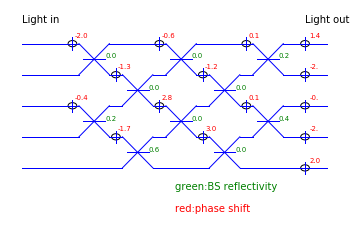

Covariance matrices before and after redecomposition are the same: True


In [112]:
def circuit_U(cov, nmodes):
    '''Decompose a circuit into squeezing gates followed by a unitary.
    
    Conducts a Williamson and Bloch-Messiah (Euler) decomposition to
    give the squeezing parameters and unitary associated with an nmodes
    modes circuit with covariance matrix cov.
    
    Args:
        cov (array): the covariance matrix
        nmodes (int): the number of circuit modes.
        
    Returns:
        tuple: an array of nmodes squeezing parameters and 
            and nmodes x nmodes unitary matrix.
    '''
    # The symplectic matrix S associated with the circuit.
    S = williamson(cov)[1]
    # The orthogonal matrix O and diagonal squeezing matrix Z associated with 
    # the circuit.
    O, Z, _ = bloch_messiah(S)
    # Squeezing paramters are the logarithm of the second half of the diagonal
    sq_r = np.log(np.diagonal(Z)[nmodes:])
    # U = X + iY, where X is the diagonal block and Y the off-diagonal block.
    U = O[:nmodes,:nmodes] + O[nmodes:2*nmodes,:nmodes] *1j
    return sq_r, U
    
    
def redecomp_circuit(old_params, r_target, nmodes, draw=False):
    '''Absorb a final squeezing gate and redecompose a circuit.
    
    Assume an input circuit with nmodes squeezing gates followed by an
    interferometer in a rectangular array (minus final phase gates), 
    followed by a squeezing gate on the last mode with squeezing 
    parameter r_target. Through the Williamson and Bloch-Messiah 
    decompositions, return a circuit with new squeezing parameters and
    a new interferometer, but no final squeezing gate.
    
    Args:
        old_params (list): the old circuit parameters, including nmodes 
            squeezing r's, nmodes * (nmodes - 1) beamsplitter theta's,
            and nmodes * (nmodes - 1) beamsplitter phi's
        r_target (float): the squeezing parameter of the target state,
            i.e. the r of the squeezing gate after the interferometer,
            acting on the final mode
        nmodes (nmodes): the number of modes of the circuit
        draw (bool): if True, draw the new interferometer
        
    Returns:
        tuple: the new squeezing parameters, followed by a unitary
            matrix corresponding to the new interferometer, followed by
            the parameters of the rectangular decomposition 
            (in the rectangular convention) of this interferometer in the 
            following order: the beamsplitter thetas, the beamsplitter
            phis, and the phis of the rotation gates at the end.
    '''
    #  The number of beamsplitters in the rectangulra array.
    nsplitters = nmodes * (nmodes - 1) // 2

    # Unpack the circuit parameters
    # Squeezing r's
    sq_r = old_params[:nmodes]
    # Beamsplitter theta's
    bs_thetas = old_params[nmodes:nmodes + nsplitters]
    # Beamsplitter phi's
    bs_phis = old_params[nmodes + nsplitters:]

    # Run the engine for the old circuit with squeezing at the end
    prog = sf.Program(nmodes)
    eng = sf.Engine('gaussian')
    with prog.context as q:
        for k in range(nmodes):
            Sgate(sq_r[k], 0) | q[k]
        apply_interferometer(
            bs_thetas, 
            bs_phis, 
            nmodes, 
            q)
        Sgate(r_target) | q[nmodes - 1]

    state = eng.run(prog).state
    cov = state.cov()
    # The squeezing parameters and circuit unitary
    sq_r, U = circuit_U(cov, nmodes)
    # Decompose U into an interferometer.
    I = itf.square_decomposition(U)
    thetas = np.array([BS[2] for BS in I.BS_list])
    phis = np.array([BS[3] for BS in I.BS_list])
    # Draw the new interferometer using the eponymous package.
    if draw:
        I.draw_interferometer()
    # Return the squeezing paramters, beamsplitter thetas and phis in the 
    # itf package convention, and the interferometer unitary U.
    return sq_r, U, thetas, phis, np.array(I.output_phases)


if __name__ == '__main__':
    # Some tests
    nmodes = 5
    nsplitters = nmodes * (nmodes - 1) // 2
    old_params = np.array(random_params(12, nmodes))
    old_rs = old_params[:nmodes]

    # Check that, if r_target == 0, the redecomposed circuit has the same
    # input squeezings, perhaps in a different order.
    r_target = 0
    new_params = redecomp_circuit(old_params, r_target, nmodes)
    new_rs = new_params[0]
    print('No virtual squeezing => same initial squeezing parameters:',
        set(abs(np.round(new_rs, 6))) == set(abs(np.round(old_rs, 6))))

    # Check that output states are the same in both decompositions.
    bs_thetas = old_params[nmodes:nmodes + nsplitters]
    bs_phis = old_params[nmodes + nsplitters:]

    r_target = 0.9
    prog = sf.Program(nmodes)
    eng = sf.Engine('gaussian')
    with prog.context as q:
        for k in range(nmodes):
            Sgate(old_rs[k], 0) | q[k]
        apply_interferometer(
            bs_thetas, 
            bs_phis, 
            nmodes, 
            q)
        Sgate(r_target, 0) | q[nmodes - 1]

    old_state = eng.run(prog).state
    old_mu = old_state.means()
    old_cov = old_state.cov()

    new_params = redecomp_circuit(old_params, r_target, nmodes, draw=True)
    new_rs = new_params[0]
    new_U = new_params[1]

    prog = sf.Program(nmodes)
    eng = sf.Engine('gaussian')
    with prog.context as q:
        for k in range(nmodes):
            Sgate(new_rs[k], 0) | q[k]
        Interferometer(new_U) | q

    new_state = eng.run(prog).state
    new_mu = new_state.means()
    new_cov = new_state.cov()
    print('Covariance matrices before and after redecomposition are the same:',
        np.all(np.round(new_cov-old_cov, 6) == 0))
    # print(new_U)

## Redecompose optimal circuit with target squeezing

Results from file:   nmax=12  nmodes=3  pattern=5&7  delta=10  ; Fidelity: 0.997, Probability: 0.001
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

Original circuit.  Virtual squeezing: -1.701; maximum squeezing: 12.000
 ____________________________________________________________________________________________________ 

This 3-mode circuit targets the state

S(0.20)(+0.661|0> - 0.343|2> + 0.253|4> - 0.037|6> + 0.377|8> + 0.323|10> + 0.365|12>)


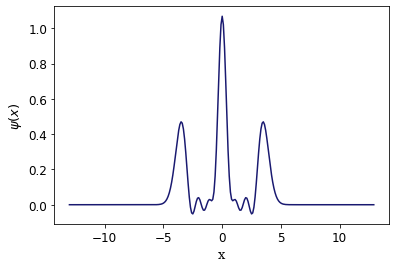


        Post-selection on measurements of the first 2 modes, and the target 
        state emerges in the last mode. Squeezing gates applied to every mode 
        at the beginning with no squeezing phases and no displacements; this is 
        followed by the most general rectangular decomposition in 3 modes
        (minus terminal phases), as follows:
        

BSgate(theta1 = 1.04, phi1 = 1.48) | (q[0], q[1])
BSgate(theta2 = 0.88, phi2 = 1.70) | (q[1], q[2])
BSgate(theta3 = 0.90, phi3 = -0.24) | (q[0], q[1])

The fidelity to the target state is 0.9963 and the probability is 0.0011. The optimal Fock cutoff is 21.


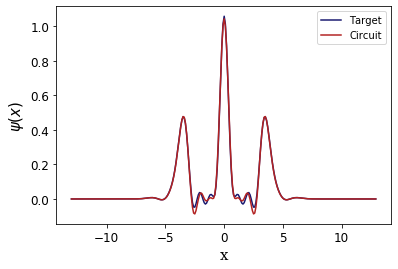

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 



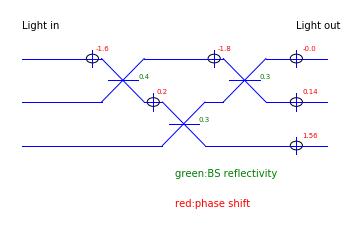

Redecomposed circuit (no losses).  New maximum squeezing: 11.346
 
 ____________________________________________________________________________________________________
This 3-mode circuit targets the state

S(0.20)(+0.661|0> - 0.343|2> + 0.253|4> - 0.037|6> + 0.377|8> + 0.323|10> + 0.365|12>)


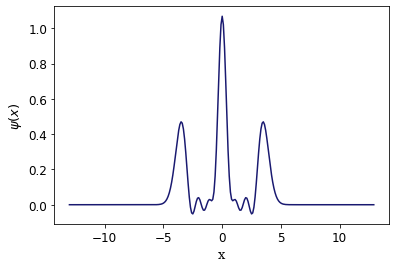


        Post-selection on measurements of the first 2 modes, and the target 
        state emerges in the last mode. Squeezing gates applied to every mode 
        at the beginning with no squeezing phases and no displacements; this is 
        followed by the most general rectangular decomposition in 3 modes
        (minus terminal phases), as follows:
        

Rgate(-1.64) | q[0]
BSgate(theta1 = 0.85, phi1 = 0.00) | (q[0], q[1])
Rgate(0.27) | q[1]
BSgate(theta2 = 0.89, phi2 = 0.00) | (q[1], q[2])
Rgate(-1.86) | q[0]
BSgate(theta3 = 0.89, phi3 = 0.00) | (q[0], q[1])

The fidelity to the target state is 0.9963 and the probability is 0.0011. The optimal Fock cutoff is 21.


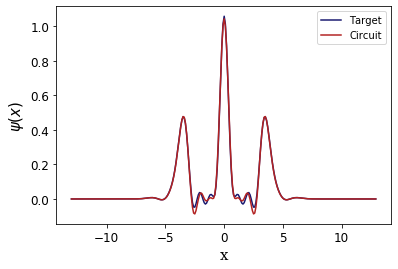

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

Lossy circuit (with losses of [-0.01 -0.01 -0.01 -0.01] dB)
 ____________________________________________________________________________________________________ 

This 3-mode circuit targets the state

S(0.20)(+0.661|0> - 0.343|2> + 0.253|4> - 0.037|6> + 0.377|8> + 0.323|10> + 0.365|12>)


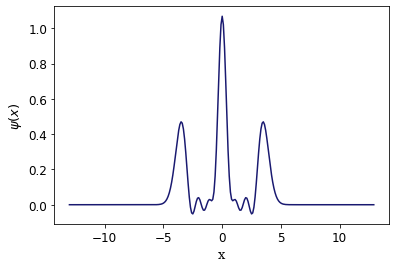


        Post-selection on measurements of the first 2 modes, and the target 
        state emerges in the last mode. Squeezing gates applied to every mode 
        at the beginning with no squeezing phases and no displacements; this is 
        followed by the most general rectangular decomposition in 3 modes
        (minus terminal phases), as follows:
        

BSgate(theta1 = 1.04, phi1 = 1.48) | (q[0], q[1])
BSgate(theta2 = 0.88, phi2 = 1.70) | (q[1], q[2])
BSgate(theta3 = 0.90, phi3 = -0.24) | (q[0], q[1])

The fidelity to the target state is 0.8809 and the probability is 0.0010. The optimal Fock cutoff is 21.


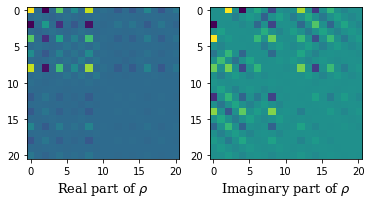

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

Redecomposed lossy circuit (with losses of [-0.01 -0.01 -0.01 -0.01] dB)
 ____________________________________________________________________________________________________ 

This 3-mode circuit targets the state

S(0.20)(+0.661|0> - 0.343|2> + 0.253|4> - 0.037|6> + 0.377|8> + 0.323|10> + 0.365|12>)


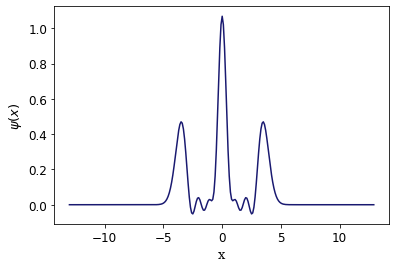


        Post-selection on measurements of the first 2 modes, and the target 
        state emerges in the last mode. Squeezing gates applied to every mode 
        at the beginning with no squeezing phases and no displacements; this is 
        followed by the most general rectangular decomposition in 3 modes
        (minus terminal phases), as follows:
        

Rgate(-1.64) | q[0]
BSgate(theta1 = 0.85, phi1 = 0.00) | (q[0], q[1])
Rgate(0.27) | q[1]
BSgate(theta2 = 0.89, phi2 = 0.00) | (q[1], q[2])
Rgate(-1.86) | q[0]
BSgate(theta3 = 0.89, phi3 = 0.00) | (q[0], q[1])

The fidelity to the target state is 0.8837 and the probability is 0.0010. The optimal Fock cutoff is 21.


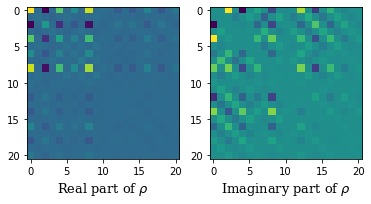

In [137]:
if __name__ == '__main__':
    D_vals = gkp_data.index.levels[1].values
#     for nmax in range(2,14,2):
#         for nmodes in range(2, mode_ceil(nmax)):
#             for delta in D_vals[:len(D_vals):5].astype(int):
#                 for cg in coarse_grainer(nmodes-1, nmax):
    for nmax in [12]:
        for nmodes in [3]:
            for delta in [10]:
                for cg in [[5, 7]]:
                    r_target, c = get_data_pt(gkp_data, nmax, delta, 0)
                    c_str = '&'.join(['{:.3f}'.format(coef) for coef in c])
                    m_str = '&'.join([str(outcome) for outcome in cg])
                    name_format = ('(nmax={})(nmodes={})(pattern={})(delta={})'
                               ''.format(nmax, nmodes, m_str, delta))
                    target = even_core(c)
                    try:
                        data = pickle.load(open('paper_data\\' +
                                                name_format + '.pickle', 'rb'))
                        params = data[0]
                        fid = data[1][0]
                        prob = data[1][1]
                        print('Results from file: ', name_format.translate(
                            {ord(i): ' ' for i in '()'}), 
                              '; Fidelity: {:.3f},'.format(fid), 
                              'Probability: {:.3f}'.format(prob))
                        
                        rmaxold = max(abs(to_db(params[:nmodes])))
                        print('+' * 100, '\n')
                        print('Original circuit. ', 
                              'Virtual squeezing: {:.3f};'.format(
                                  to_db(r_target)),
                              'maximum squeezing: {:.3f}\n'.format(rmaxold),
                              100*'_', '\n')
                        
                        fock_circuit(params, 
                                     target, cg, nmodes, give_rho=True, 
                                     specs=True, r_final=r_target)

                        print('+' * 100, '\n')
                                                
                        r_new, U_new, thetas_new, phis_new, final_phis_new = \
                        redecomp_circuit(params, r_target, nmodes, draw=True)
                        new_params = np.concatenate(
                            (r_new, thetas_new, phis_new))
                        rmaxnew = max(abs(to_db(r_new)))
                        print('Redecomposed circuit (no losses). ', 
                              'New maximum squeezing: {:.3f}\n'.format(rmaxnew),
                              '\n', 100 * '_')
                        
                        
                        fock_circuit(new_params, 
                                     target, cg, nmodes, give_rho=True, 
                                     specs=True, r_virt=r_target,
                                     final_phis=final_phis_new, conv='itf')
                        
                        losses_dB = -np.array([0.01, 0.01, 0.01, 0.01])
                        losses = 10**(losses_dB/10)
                        print('+' * 100, '\n')
                        print('Lossy circuit '
                              '(with losses of {} dB)\n'.format(losses_dB),
                              '_' * 100, '\n')
                        
                        fock_circuit(params, 
                                     target, cg, nmodes, give_rho=True, 
                                     specs=True, r_final=r_target,
                                     loss_Ts=losses)
                    
                        print('+' * 100, '\n')
                        print('Redecomposed lossy circuit '
                              '(with losses of {} dB)\n'.format(losses_dB),
                              '_' * 100, '\n')
        
                        fock_circuit(new_params, target, cg, nmodes, 
                                     loss_Ts=losses, give_rho=True, 
                                     specs=True, r_virt=r_target, 
                                     final_phis=final_phis_new, conv='itf')

                    except Exception:
                        traceback.print_exc()
                        pass